In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import os
import pandas as pd
import xml.etree.ElementTree as ET
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
import cv2 as cv

from tqdm import tqdm 

In [5]:
device = torch.device("cuda")

### Model

S x S grid

predicitons = S * S * ( B * 5 + C )

24 convs + 2 fc

pretrain conv on ImageNet

input image = 448 * 448

output = 7 * 7 * 30

In [ ]:
class ConvLayers(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=192, kernel_size=7, stride=2, padding=3)  
        self.bn1 = nn.BatchNorm2d(192)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=192, out_channels=256, kernel_size=3, padding=1)  
        self.bn2 = nn.BatchNorm2d(256)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),  
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512)
        )
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3_5 = nn.Sequential(
            *[nn.Sequential(
                nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1),
                nn.BatchNorm2d(256),
                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
            ) for _ in range(4)]
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
        )
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4_5 = nn.Sequential(
            *[nn.Sequential(
                nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1),
                nn.BatchNorm2d(512),
                nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),  
                nn.BatchNorm2d(1024),
            ) for _ in range(2)]
        )
        
        # The upper layers are used for pretraining on ImageNet
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),  
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(1024),
        )
        
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),  
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024)
        )
    
    def preTrain(self, x):
        x = self.maxpool1(F.leaky_relu(self.conv1(x)))
        x = self.maxpool2(F.leaky_relu(self.conv2(x)))
        x = self.maxpool3(F.leaky_relu(self.conv3(x)))
        x = self.maxpool4(F.leaky_relu(self.conv4(x)))
        
        return x
    
    def forward(self, x):
        x = self.maxpool1(F.leaky_relu(self.conv1(x)))
        x = self.maxpool2(F.leaky_relu(self.conv2(x)))
        x = self.maxpool3(F.leaky_relu(self.conv3(x)))
        x = self.maxpool4(F.leaky_relu(self.conv4(x)))
        x = F.leaky_relu(self.conv5(x))
        x = F.leaky_relu(self.conv6(x))
        
        return x

In [71]:
class FCLayers(nn.Module):
    def __init__(self, S, B, C):
        super().__init__()
        self.S = S
        self.B = B
        self.C = C
        self.fc1 = nn.Linear(self.S*self.S*1024, 4096)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(4096, self.S * self.S* (self.B * 5 + self.C))
        
    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = F.gelu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [72]:
class YOLOv1(nn.Module):
    def __init__(self, S=7, B=2, C=20):
        super().__init__()
        
        self.S = S
        self.B = B
        self.C = C
        self.coord_scale = 5
        self.noobj_scale = 0.5
        
        self.convLayers = ConvLayers()
        self.fcLayers = FCLayers(self.S, self.B, self.C)
        
    def forward(self, x):
        x = self.convLayers(x)
        x = self.fcLayers(x)
        x = x.view(-1, self.S, self.S, self.B * 5 + self.C)
        return x
    
    def loss_fn(self, predictions, targets):
        pred_bboxes, pred_confs, pred_classes, _ = self.destruct(predictions)
        true_bboxes, true_confs, true_classes, _ = self.destruct(targets)

        iou = self.findIOU(pred_bboxes, true_bboxes)
        best_iou_mask = self.get_best_iou_mask(iou)

        obj_mask = true_confs > 0 
        no_obj_mask = ~obj_mask   

        responsible_mask = torch.zeros_like(pred_confs, dtype=torch.bool)
        responsible_mask.scatter_(-1, best_iou_mask, 1)

        xy_loss = F.mse_loss(
            pred_bboxes[..., :2][obj_mask & responsible_mask],
            true_bboxes[..., :2][obj_mask & responsible_mask],
            reduction='sum'
        )
        wh_loss = F.mse_loss(
            torch.sqrt(torch.clamp(pred_bboxes[..., 2:4][obj_mask & responsible_mask], min=1e-6)),
            torch.sqrt(torch.clamp(true_bboxes[..., 2:4][obj_mask & responsible_mask], min=1e-6)),
            reduction='sum'
        )

        bbox_loss = self.coord_scale * (xy_loss + wh_loss)

        obj_conf_loss = F.mse_loss(
            pred_confs[obj_mask & responsible_mask],
            true_confs[obj_mask & responsible_mask],
            reduction='sum'
        )
        
        no_obj_conf_loss = F.mse_loss(
            pred_confs[no_obj_mask],
            true_confs[no_obj_mask],
            reduction='sum'
        )
        conf_loss = obj_conf_loss + self.noobj_scale * no_obj_conf_loss

        grid_obj_mask = obj_mask.any(dim=-1)

        class_loss = F.mse_loss(
            pred_classes[grid_obj_mask],
            true_classes[grid_obj_mask],
            reduction='sum'
        )

        total_loss = bbox_loss + conf_loss + class_loss
        return total_loss / predictions.shape[0] 
    
    def destruct(self, x, B=None):
        if B is None:
            B = self.B 
        bboxes_and_confs = x[..., :B * 5].view(-1, self.S, self.S, B, 5)
        bboxes = bboxes_and_confs[..., :4]
        confs = bboxes_and_confs[..., 4]
        classes = x[..., -self.C:]
        
        return bboxes, confs, classes, bboxes_and_confs
    
    def findIOU(self, pred_bboxes, true_bboxes):
        pred_tl, pred_br = self.bbox_to_coords(pred_bboxes)
        true_tl, true_br = self.bbox_to_coords(true_bboxes)
        
        inter_tl = torch.max(pred_tl, true_tl)
        inter_br = torch.min(pred_br, true_br)
        inter_wh = torch.clamp(inter_br - inter_tl, min=0)
        intersection = inter_wh[..., 0] * inter_wh[..., 1]

        pred_area = (pred_br[..., 0] - pred_tl[..., 0]) * (pred_br[..., 1] - pred_tl[..., 1])
        true_area = (true_br[..., 0] - true_tl[..., 0]) * (true_br[..., 1] - true_tl[..., 1])
        union = pred_area + true_area - intersection

        iou = intersection / (union + 1e-6)
        iou[union == 0] = 0 

        return iou

    def bbox_to_coords(self, bboxes):
        x, y, w, h = bboxes[..., 0], bboxes[..., 1], bboxes[..., 2], bboxes[..., 3]
        tl = torch.stack((x - w / 2, y - h / 2), dim=-1)
        br = torch.stack((x + w / 2, y + h / 2), dim=-1)
        return tl, br

    def get_best_iou_mask(self, iou):
        best_iou_idx = torch.argmax(iou, dim=-1)
        return best_iou_idx.unsqueeze(-1)

### Dataset

In [9]:
files_dir = 'dataset_fruit/train_zip/train'
test_dir = 'dataset_fruit/test_zip/test'

images = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.jpg']
annots = []
for image in images:
    annot = image[:-4] + '.xml'
    annots.append(annot)
    
images = pd.Series(images, name='images')
annots = pd.Series(annots, name='annots')
df = pd.concat([images, annots], axis=1)
df = pd.DataFrame(df)

test_images = [image for image in sorted(os.listdir(test_dir))
                        if image[-4:]=='.jpg']

test_annots = []
for image in test_images:
    annot = image[:-4] + '.xml'
    test_annots.append(annot)

test_images = pd.Series(test_images, name='test_images')
test_annots = pd.Series(test_annots, name='test_annots')
test_df = pd.concat([test_images, test_annots], axis=1)
test_df = pd.DataFrame(test_df)

In [73]:
class FruitImagesDataset(Dataset):
    def __init__(self, df, files_dir, S=7, B=2, C=3, transform=None, image_size=(416, 416)):
        self.annotations = df
        self.files_dir = files_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C
        self.image_size = image_size
        self.resize = Resize(self.image_size)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.files_dir, self.annotations.iloc[index, 1])
        boxes = []
        tree = ET.parse(label_path)
        root = tree.getroot()

        class_dictionary = {'apple': 0, 'banana': 1, 'orange': 2}

        img_path = os.path.join(self.files_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path).convert("RGB")

        img_width, img_height = image.size
        for member in root.findall('object'):
            klass = member.find('name').text
            klass = class_dictionary[klass]
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)

            centerx = ((xmax + xmin) / 2) / img_width
            centery = ((ymax + ymin) / 2) / img_height
            boxwidth = (xmax - xmin) / img_width
            boxheight = (ymax - ymin) / img_height

            boxes.append([klass, centerx, centery, boxwidth, boxheight])

        boxes = torch.tensor(boxes)
        image = self.resize(image)
        image = ToTensor()(image)

        if self.transform:
            image, boxes = self.transform(image, boxes)

        label_matrix = torch.zeros((self.S, self.S, 5 * self.B + self.C))

        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            width_cell, height_cell = width, height

            for b in range(self.B):
                if label_matrix[i, j, 5 * b + 4] == 0:  
                    label_matrix[i, j, 5 * b:5 * b + 5] = torch.tensor(
                        [x_cell, y_cell, width_cell, height_cell, 1] 
                    )
                    break

            label_matrix[i, j, 5 * self.B + class_label] = 1

        return image.to(device), label_matrix.to(device)

In [28]:
def draw_bbox(im, label, conf_thresh=0.8):
    S = 7
    B = 2
    C = 3
    image = im.permute(1, 2, 0).numpy()
    image = image.copy()
    image = (image * 255).astype('uint8')
    img_height, img_width = image.shape[:2]
    section_width = img_width / S
    section_height = img_height / S
    
    for i in range(S):
        for j in range(S):
            grid = label[i, j]   
            bbox1_conf = grid[4]
            bbox2_conf = grid[9]
            
            if(bbox1_conf >= bbox2_conf):
                bbox = grid[:5]
                conf = bbox1_conf
            else:
                bbox = grid[5:10]
                conf = bbox2_conf
                
            if conf < conf_thresh:
                continue    
            
            '''
                The (x, y) coordinates represent the center of the box #* relative to the bounds of the grid cell. 
                The width and height are predicted #* relative to the whole image.
            '''

            x, y, w, h = bbox[:4].tolist()
            
            cell_x = j * section_width
            cell_y = i * section_height
            
            cv.rectangle(image, (int(cell_x), int(cell_y)),
                                (int(cell_x + section_width), int(cell_y + section_height)),
                                (0, 255, 0), 2)
            
            center_x = cell_x + x * section_width
            center_y = cell_y + y * section_height
            
            cv.circle(image, (int(center_x), int(center_y)), 1, (0, 0, 255), 3)
            
            box_width = w * img_width
            box_height = h * img_height

            top_left_x = center_x - box_width / 2
            top_left_y = center_y - box_height / 2
            
            top_left_x = int(top_left_x)
            top_left_y = int(top_left_y)
            box_width = int(box_width)
            box_height = int(box_height)
            
            cv.rectangle(image, (top_left_x, top_left_y),
                                (top_left_x + box_width, top_left_y + box_height),
                                (255, 0, 140), 2)
            
    return image

In [91]:
BATCH_SIZE = 16
image_size = 448

train_dataset = FruitImagesDataset(
    files_dir=files_dir,
    df=df,
    image_size=(image_size, image_size),
    S=7,
    B=2,
)

test_dataset = FruitImagesDataset(
    files_dir=test_dir,
    df=df,
    image_size=(image_size, image_size),
    S=7,
    B=2,
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False,
)

In [ ]:
fig, axs = plt.subplots(4, BATCH_SIZE//4)

fig.set_figwidth(100)
fig.set_figheight(100)

j = 0
for i in range(BATCH_SIZE):
    images, labels = train_dataset.__getitem__(i)
    im = draw_bbox(images.cpu(), labels.cpu())
    axs[j, i % (BATCH_SIZE // 4)].imshow(im)
    axs[j, i % (BATCH_SIZE // 4)].axis('off')
    
    if (i + 1) % (BATCH_SIZE // 4) == 0:
        j += 1

plt.tight_layout()
plt.show()

In [ ]:
lr = 1e-1
model = YOLOv1(S=7, B=2, C=3)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = model.loss_fn

In [79]:
images, targets = next(iter(train_loader))

In [ ]:
losses = []
ud = []

epochs = 10
for epoch in range(epochs):
    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        pred = model(images)
        
        optimizer.zero_grad()
        loss = loss_fn(pred, targets)
        print('LOSS ', loss.log10().item())
        loss.backward()
        
        optimizer.step()
        
        with torch.no_grad():
            losses.append(loss.log10().item())
            ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in model.parameters() if p.grad is not None])

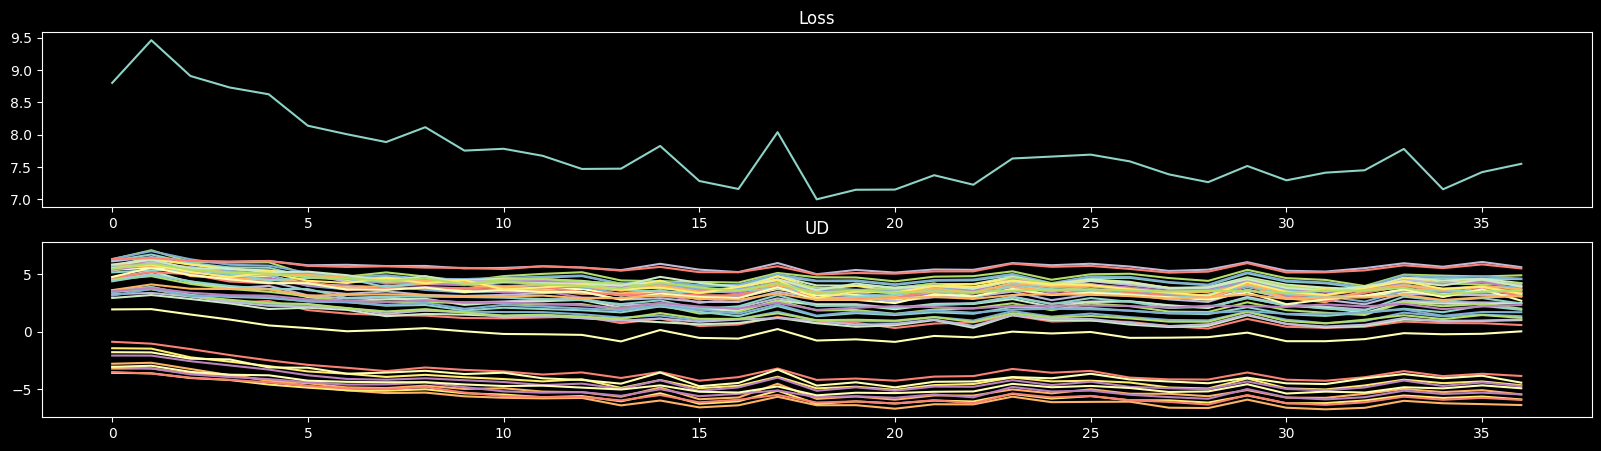

In [81]:
fig, axs = plt.subplots(2, 1, figsize=(20, 5))

axs[0].plot(losses)
axs[0].set_title("Loss")

axs[1].plot(ud)
axs[1].set_title("UD")

plt.show()